In [1]:
import os
import warnings
import time
import threading
import seaborn as sns
from sklearn.metrics import mean_squared_error
from source.jabba import JABBA
from software.qabba import fastQABBA, fastQABBA_len, fastQABBA_inc
from source.jabba import JABBA
from software.qabba import QABBA
from fABBA import fABBA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('bmh')
# warnings.filterwarnings("error")

/home/chenxinye/qabba/source/jabba/jabba.py:22: UserWarning: cython fail.
  warnings.warn("cython fail.")


ModuleNotFoundError: No module named 'torch'

In [2]:
num = 5000
mu, sigma = 0, 1
tol, alpha = 0.01, 0.1
quantized_bits = [4, 8, 12, 16, 20, 24, 28, 32]
num_data = 100

err_fabba = np.zeros(num_data)
err_qabba_len = np.zeros((num_data, len(quantized_bits)))
err_qabba_inc = np.zeros((num_data, len(quantized_bits)))
partition = 1
for rd in tqdm(range(num_data)):
    np.random.seed(rd)
    synthetic_ts = np.random.normal(mu, sigma, num)
    # synthetic_ts = (synthetic_ts - synthetic_ts.mean()) / synthetic_ts.std()
    fabba = fABBA(tol=tol, alpha=alpha, sorting='norm', verbose=0)
    symbs_fabba = fabba.fit_transform(synthetic_ts)
    reconst_fabba = fabba.inverse_transform(symbs_fabba, synthetic_ts[0])
    minlen = min(len(reconst_fabba), len(synthetic_ts))
    err_fabba[rd] = mean_squared_error(synthetic_ts[:minlen], reconst_fabba[:minlen])
    
    for b in range(len(quantized_bits)):
        bit = quantized_bits[b]
        qabba = fastQABBA_inc(tol=tol, alpha=alpha, bits_for_len=32, bits_for_inc=bit, verbose=0)
        symbs_qabba = qabba.transform(synthetic_ts)
        reconst_qabba = qabba.inverse_transform(symbs_qabba, synthetic_ts[0])
        minlen = min(len(reconst_qabba), len(synthetic_ts))
        err_qabba_inc[rd, b] = mean_squared_error(synthetic_ts[:minlen], reconst_qabba[:minlen])
        
    for b in range(len(quantized_bits)):
        bit = quantized_bits[b]
        qabba = fastQABBA_len(tol=tol, alpha=alpha, bits_for_len=bit, bits_for_inc=32, verbose=0)
        symbs_qabba = qabba.transform(synthetic_ts)
        reconst_qabba = qabba.inverse_transform(symbs_qabba, synthetic_ts[0])
        minlen = min(len(reconst_qabba), len(synthetic_ts))
        err_qabba_len[rd, b] = mean_squared_error(synthetic_ts[:minlen], reconst_qabba[:minlen])
    

100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


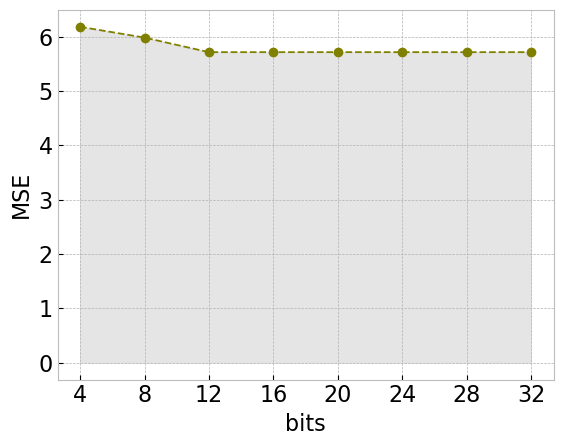

In [3]:
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(quantized_bits, (err_qabba_len.mean(axis=0) - np.mean(err_fabba)), linewidth=1.3, linestyle='--',
         label='Quantization', markersize=6, marker='o', color='olive')

# plt.plot(quantized_bits, [np.mean(err_fabba)]*8, linewidth=1.5, linestyle=':',
#          label='Non-quantization', markersize=6, marker='*')

plt.fill_between(quantized_bits, (err_qabba_len.mean(axis=0) - np.mean(err_fabba)), 0, color='grey', alpha=0.2)
plt.xticks(quantized_bits)
plt.xlabel("bits", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('MSE', fontsize=16)

# plt.title('len', fontsize=16)
# plt.grid(True)
# plt.legend(fontsize=16, loc='best')
plt.savefig('figs/mse_qlen.pdf', bbox_inches='tight') 
plt.show()

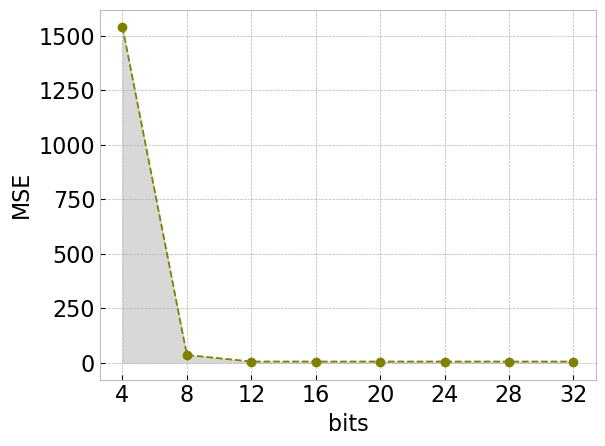

In [4]:
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(quantized_bits, (err_qabba_inc.mean(axis=0) - np.mean(err_fabba)), linewidth=1.3, linestyle='--',
         label='Quantization', markersize=6, marker='o', color='olive')

# plt.plot(quantized_bits, [np.mean(err_fabba)]*8, linewidth=1.5, linestyle=':',
#          label='Non-quantization', markersize=6, marker='*')

plt.fill_between(quantized_bits, (err_qabba_inc.mean(axis=0) - np.mean(err_fabba)), 0, color='grey', alpha=0.3)
plt.xticks(quantized_bits)
plt.xlabel("bits", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('MSE', fontsize=16)

# plt.title('len', fontsize=16)
# plt.grid(True)
# plt.legend(fontsize=16, loc='best')
plt.savefig('figs/mse_qinc.pdf', bbox_inches='tight') 
plt.show()

In [3]:

import numpy as np
import warnings 


class quant():
    """
    Parameters
    ----------
    bits : int, default=8
        The bitwidth of integer format, the larger it is, the wider range the quantized value can be.
        
    sign : bool, default=1
        Whether or not to quantize the value to symmetric integer range.
    
    zpoint : bool, default=1
        Whether or not to compute the zero point. If `zpoint=0`, then the quantized range must be symmetric.
        
    rd_func : function, default=None
        The rounding function used for the quantization. The default is round to nearest.
        
    clip_range : list, default=None
        The clipping function for the quantization.
        
    epsilon : double, default=1e-12
        When the x is comprised of single value, then the scaling factor will be (b - a + epsilon) / (alpha - beta)
        for mapping [a, b] to [alpha, beta].
        
    Methods
    ----------
    quant(x):
        Method that quantize ``x`` to the user-specific arithmetic format.
        
    """
    def __init__(self, bits=8, sign=1, zpoint=1, rd_func=None, clip_range=None, epsilon=1e-12):
        self.bits = bits
        self.sign = sign
        self.zpoint = zpoint
        
        self.rd_func = rd_func
        self.clip_range = clip_range
        self.epsilon = epsilon 
        
        if bits in {8, 16, 32, 64}:
            if bits == 8:
                self.intType = np.int8
                
            elif bits == 16:
                self.intType = np.int16
                
            elif bits == 32:
                self.intType = np.int32
                
            elif bits == 64:
                self.intType = np.int64
                
        else:
            warnings.warn("Current int type not support this bitwidth, use int64 to simulate.")
            self.intType = np.int64
        
        if self.sign == 1:
            if self.zpoint == 1:
                self.alpha_q = -2**(self.bits - 1)
                self.beta_q = 2**(self.bits - 1) - 1
            else:
                self.beta_q = 2**(self.bits - 1) - 1
                self.alpha_q = -self.beta_q
                
        else:
            if self.zpoint == 0:
                self.beta_q = 2**(self.bits - 1) - 1
                self.alpha_q = -self.beta_q
            else:
                raise ValueError('Please set `zpoint` to 0.')
        
        if self.rd_func is None:
            self.rd_func = lambda x: np.round(x, decimals=0)
            
        if self.clip_range is None:
            self.clip_func = lambda x: np.clip(x, a_min=self.alpha_q, a_max=self.beta_q)
        else:
            self.clip_func = lambda x: np.clip(x, a_min=self.clip_range[0], a_max=self.beta_q[self.clip_range[1]])
            
            
    def __call__(self, x):
        x_min = np.min(x)
        x_max = np.max(x)
        
        if self.sign != 1:
            abs_max = max(abs(x_min), abs(x_max))
            x_min = -abs_max
            x_max = abs_max
            
        self.scaling, self.zpoint = self.compute_scaling(x_min, x_max, self.alpha_q, self.beta_q)
        
        try:
            x_q = self.quantization(x, self.scaling, self.zpoint)
        except:
            self.scaling, self.zpoint = self.compute_scaling(x_min, x_max+self.epsilon, self.alpha_q, self.beta_q)
            x_q = self.quantization(x, self.scaling, self.zpoint)
            
        return x_q
        
    def dequant(self, x_q):
        return self.dequantization(x_q, self.scaling, self.zpoint)
        
    def quantization(self, x, s, z):
        x_q = self.rd_func((x - z)/s)
        x_q = self.intType(self.clip_func(x_q))
        return x_q

    def dequantization(self, x_q, s, z):
        x_q = x_q.astype(np.float32)
        x = s * x_q + z
        return x

    def compute_scaling(self, alpha, beta, alpha_q, beta_q):
        s = (beta - alpha) / (beta_q - alpha_q)
        z = (alpha * beta_q - beta * alpha_q) / (beta_q - alpha_q)

        return s, z
    

In [48]:
import numpy as np
from numpy import linalg as LA


X = np.random.randn(100, 10)

In [49]:
Xn = (X - X.min())/(X.max() - X.min())

BITS = 8
qt = quant(bits=BITS)
Xr = qt.dequant(qt(Xn))
LA.norm(Xn - Xr, 'fro')

0.03540361816012154

In [50]:
bound = np.prod(Xn.shape) * (np.max(Xn) - np.min(Xn)) / (2**(BITS+1) - 2)
np.sqrt(bound)

1.4002800840280099

In [51]:
X =  np.random.uniform(-1,1,(100, 10))
Xn = (X - X.min())/(X.max() - X.min())

BITS = 8
qt = quant(bits=BITS)
Xr = qt.dequant(qt(Xn))
LA.norm(Xn - Xr, 'fro')

0.035976784849242396

In [52]:
bound = np.prod(Xn.shape) * (np.max(Xn) - np.min(Xn)) / (2**(BITS+1) - 2)
np.sqrt(bound)

1.4002800840280099

In [53]:
np.prod(Xn.shape) 

1000